# Traditional TS

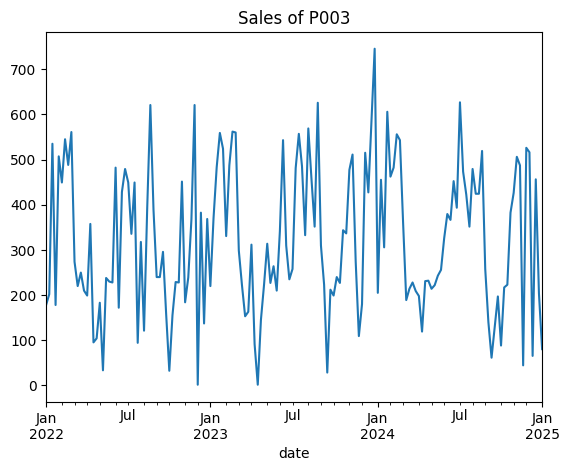

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.exponential_smoothing import ets
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error

# Load and prepare the data
df = pd.read_csv('../data/retail_demand_dataset.csv', parse_dates=['date'], index_col='date')
one_product = df[df['product_id'] == 'P003']['units_sold']
series = one_product.resample('W').sum()

# Split into train and test sets
train = series[:-52]  # First two years for training
test = series[-52:]   # Last year for testing

# Plot
series.plot(kind='line', xlabel='date', title="Sales of P003")
plt.show()

## Testing for Stationarity

In [2]:
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')

    if result[1] <= 0.05:
        print("Series is stationary")
        return True
    else:
        print("Series is not stationary - differencing required")
        return False

print("Original Series:")
is_stationary = check_stationarity(train)

Original Series:
ADF Statistic: -7.1201
p-value: 0.0000
Critical Values:
	1%: -3.4942
	5%: -2.8895
	10%: -2.5817
Series is stationary


If the series isn't stationary (p-value > 0.05), we difference it:

In [3]:
if is_stationary:
    train_diff = train
else:
    # First difference if needed
    train_diff = train.diff().dropna()
    print("After First Differencing:")
    check_stationarity(train_diff)

## Identifying Seasonality and Model Parameters

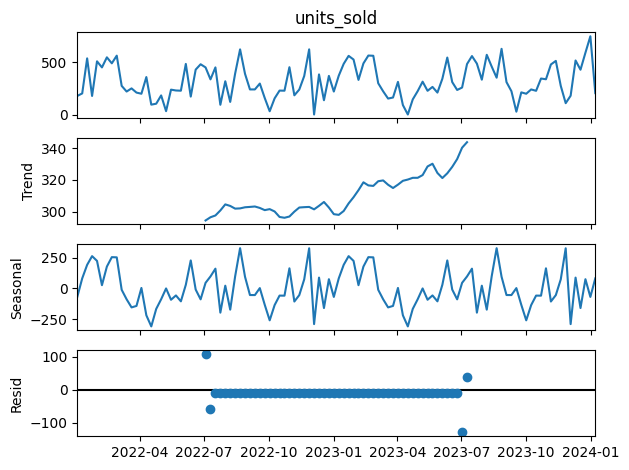

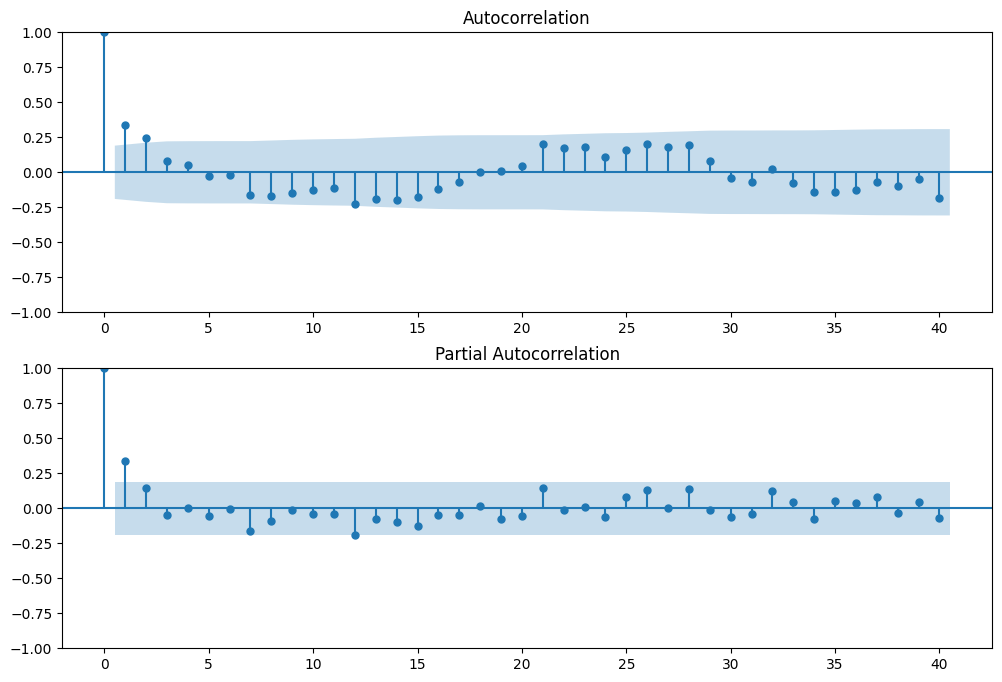

In [4]:
# Seasonal decomposition
decomposition = seasonal_decompose(train, model='additive')
decomposition.plot()
plt.show()

# ACF and PACF plots to identify AR and MA terms
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train_diff, ax=ax1, lags=40)
plot_pacf(train_diff, ax=ax2, lags=40)
plt.show()

## Model 1: Exponential Smoothing (ETS)

In [5]:
# Fit Exponential Smoothing model (assuming additive seasonality)
ets_model = ets.ETSModel(train, trend='add', seasonal='add', seasonal_periods=52)
ets_fit = ets_model.fit()

# Generate a forecast for the test period
ets_forecast = ets_fit.forecast(len(test))
print(f'ETS AIC: {ets_fit.aic:.2f}, MAE: {ets_fit.mae:.2f} and MSE: {ets_fit.mse:.2f}')

ETS AIC: 1421.84, MAE: 90.39 and MSE: 13112.53


## Model 2: ARIMA

In [6]:
# Fit ARIMA model based on our analysis
arima_model = ARIMA(train_diff, order=(3, 0, 1))
arima_fit = arima_model.fit()

# Generate forecast
arima_forecast = arima_fit.forecast(len(test))
print(f'ETS AIC: {arima_fit.aic:.2f}, MAE: {arima_fit.mae:.2f} and MSE: {arima_fit.mse:.2f}')

ETS AIC: 1376.62, MAE: 125.64 and MSE: 22824.08


## Model Diagnostics


--- ARIMA Model Diagnostics ---


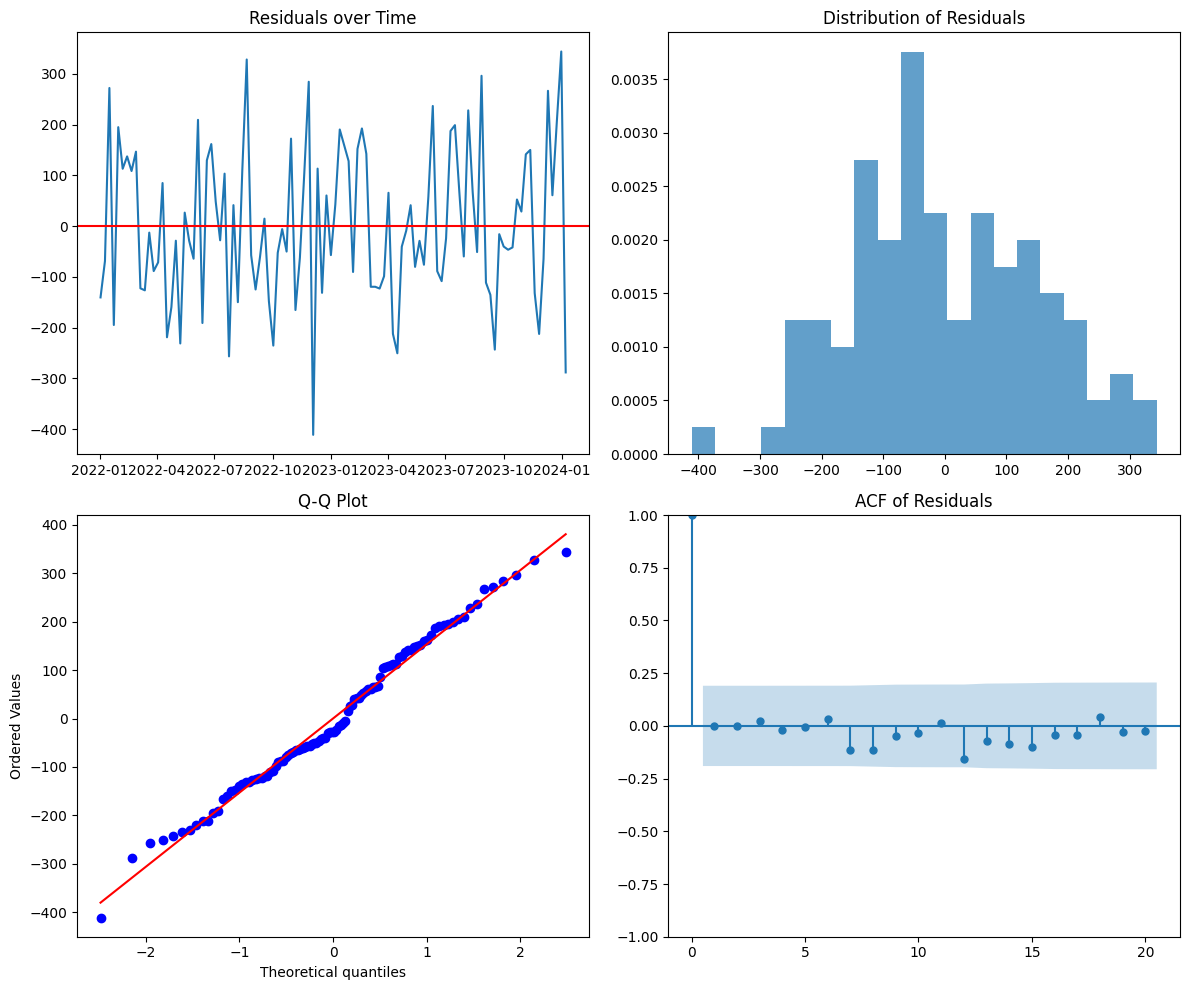

Ljung-Box Test p-value: 0.9628
Residuals are independent (good!)


In [7]:
def diagnose_model(model_fit, model_name):
    print(f"\n--- {model_name} Diagnostics ---")

    # Get residuals
    residuals = model_fit.resid.dropna()

    # Plot residuals
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Residuals over time
    axes[0,0].plot(residuals)
    axes[0,0].set_title('Residuals over Time')
    axes[0,0].axhline(y=0, color='r', linestyle='-')

    # Distribution of residuals
    axes[0,1].hist(residuals, bins=20, density=True, alpha=0.7)
    axes[0,1].set_title('Distribution of Residuals')

    # Q-Q plot for normality
    stats.probplot(residuals, dist="norm", plot=axes[1,0])
    axes[1,0].set_title('Q-Q Plot')

    # ACF of residuals
    plot_acf(residuals, ax=axes[1,1], lags=20)
    axes[1,1].set_title('ACF of Residuals')

    plt.tight_layout()
    plt.show()

    # Ljung-Box test for autocorrelation in residuals
    lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
    print(f"Ljung-Box Test p-value: {lb_test['lb_pvalue'].iloc[-1]:.4f}")
    if lb_test['lb_pvalue'].iloc[-1] > 0.05:
        print("Residuals are independent (good!)")
    else:
        print("Residuals show autocorrelation (problem!)")

# Run diagnostics
diagnose_model(arima_fit, "ARIMA Model")

## Evaluation

ETS Model MAE: 149.38
ARIMA Model MAE: 138.77


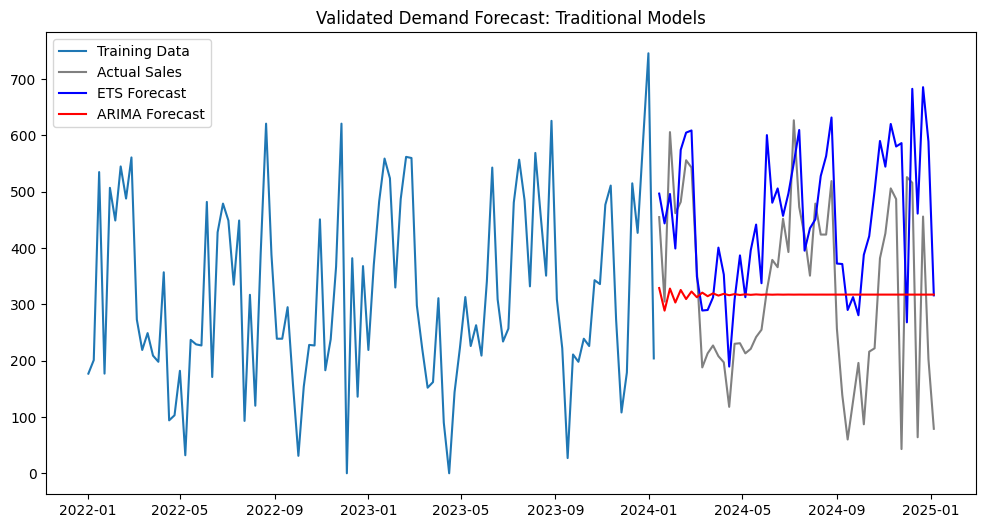

In [8]:
ets_mae = mean_absolute_error(test, ets_forecast)
arima_mae = mean_absolute_error(test, arima_forecast)

print(f"ETS Model MAE: {ets_mae:.2f}")
print(f"ARIMA Model MAE: {arima_mae:.2f}")

# Visualize the final forecasts
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Sales', color='grey')
plt.plot(test.index, ets_forecast, label='ETS Forecast', color='blue')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('Validated Demand Forecast: Traditional Models')
plt.show()

# ML

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

## Creating Temporal Features

In [16]:
# Create comprehensive features for time series ML
def create_features(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df.index)

    # Basic date features
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['is_weekend'] = (df['date'].dt.dayofweek >= 5).astype(int)

    # Cyclical encoding for periodic features
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

    # Holiday proximity (days until next major holiday)
    def days_to_holiday(date):
        holidays = {
            'christmas': pd.Timestamp(f'{date.year}-12-25'),
            'new_year': pd.Timestamp(f'{date.year+1}-01-01'),
            'july_4': pd.Timestamp(f'{date.year}-07-04')
        }
        min_days = 365
        for holiday in holidays.values():
            days = abs((date - holiday).days)
            min_days = min(min_days, days)
        return min_days

    df['days_to_holiday'] = df['date'].apply(days_to_holiday)

    return df

# Apply feature engineering
df_enhanced = create_features(df).reset_index(drop=True)
print(df_enhanced.head())

  product_id     category  base_price  selling_price  promotion  holiday  \
0       P001  Electronics      299.99         299.99          0      1.0   
1       P001  Electronics      299.99         299.99          0      0.0   
2       P001  Electronics      299.99         299.99          0      0.0   
3       P001  Electronics      299.99         299.99          0      0.0   
4       P001  Electronics      299.99         299.99          0      0.0   

   units_sold  revenue  year  month  ...  is_weekend       date  day_of_month  \
0         5.0  1499.95  2022      1  ...           1 2022-01-01             1   
1         4.0  1199.96  2022      1  ...           1 2022-01-02             2   
2         2.0   599.98  2022      1  ...           0 2022-01-03             3   
3         2.0   599.98  2022      1  ...           0 2022-01-04             4   
4         3.0   899.97  2022      1  ...           0 2022-01-05             5   

  week_of_year  quarter  day_of_week_sin  day_of_week_co

## Creating Lag and Window Features

In [17]:
# Create lag and rolling window features for a specific product
def create_lag_features(df, product_id, lag_periods=[1, 7, 14, 28], window_sizes=[7, 28]):
    product_df = df[df['product_id'] == product_id].copy().sort_values('date')

    # Lag features
    for lag in lag_periods:
        product_df[f'lag_{lag}'] = product_df['units_sold'].shift(lag)

    # Rolling statistics
    for window in window_sizes:
        product_df[f'rolling_mean_{window}'] = product_df['units_sold'].shift(1).rolling(window=window).mean()
        product_df[f'rolling_std_{window}'] = product_df['units_sold'].shift(1).rolling(window=window).std()
        product_df[f'rolling_max_{window}'] = product_df['units_sold'].shift(1).rolling(window=window).max()

    # Price change features
    product_df['price_change_1d'] = product_df['selling_price'].pct_change(1)
    product_df['price_change_7d'] = product_df['selling_price'].pct_change(7)

    return product_df

# Let's use our star product P003
product_ml = create_lag_features(df_enhanced, 'P003')
print(product_ml.head())

     product_id  category  base_price  selling_price  promotion  holiday  \
2192       P003  Clothing       49.99          49.99          0      1.0   
2193       P003  Clothing       49.99          49.99          0      0.0   
2194       P003  Clothing       49.99          49.99          0      0.0   
2195       P003  Clothing       49.99          49.99          0      0.0   
2196       P003  Clothing       49.99          39.82          1      0.0   

      units_sold  revenue  year  month  ...  lag_14  lag_28  rolling_mean_7  \
2192       101.0  5048.99  2022      1  ...     NaN     NaN             NaN   
2193        76.0  3799.24  2022      1  ...     NaN     NaN             NaN   
2194        71.0  3549.29  2022      1  ...     NaN     NaN             NaN   
2195        69.0  3449.31  2022      1  ...     NaN     NaN             NaN   
2196        61.0  2429.02  2022      1  ...     NaN     NaN             NaN   

     rolling_std_7  rolling_max_7  rolling_mean_28  rolling_std_28  

/var/folders/vp/x7gwfv1n06n4s0gby6d_yt0r0000gn/T/ipykernel_61370/135562575.py:16: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  product_df['price_change_1d'] = product_df['selling_price'].pct_change(1)
/var/folders/vp/x7gwfv1n06n4s0gby6d_yt0r0000gn/T/ipykernel_61370/135562575.py:17: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  product_df['price_change_7d'] = product_df['selling_price'].pct_change(7)


## Training ML Model

In [18]:
# Prepare features and target
feature_columns = [
    'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
    'is_weekend', 'days_to_holiday', 'promotion', 'holiday',
    'lag_1', 'lag_7', 'lag_14', 'lag_28',
    'rolling_mean_7', 'rolling_std_7', 'rolling_mean_28',
    'price_change_1d', 'price_change_7d'
]

# Remove rows with NaN values (from lag features)
product_ml_clean = product_ml.dropna(subset=feature_columns + ['units_sold'])

# Split chronologically (important for time series!)
split_date = '2024-01-01'
train_mask = product_ml_clean['date'] < split_date
test_mask = product_ml_clean['date'] >= split_date

X_train = product_ml_clean[train_mask][feature_columns]
X_test = product_ml_clean[test_mask][feature_columns]
y_train = product_ml_clean[train_mask]['units_sold']
y_test = product_ml_clean[test_mask]['units_sold']

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

# Train Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Generate predictions
y_pred_rf = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"ARIMA Baseline MAE: {arima_mae:.2f}")
print(f"Improvement: {((arima_mae - rf_mae) / arima_mae * 100):.1f}%")

Training samples: 113, Test samples: 158
Random Forest MAE: 16.21
ARIMA Baseline MAE: 138.77
Improvement: 88.3%


## Feature Importance

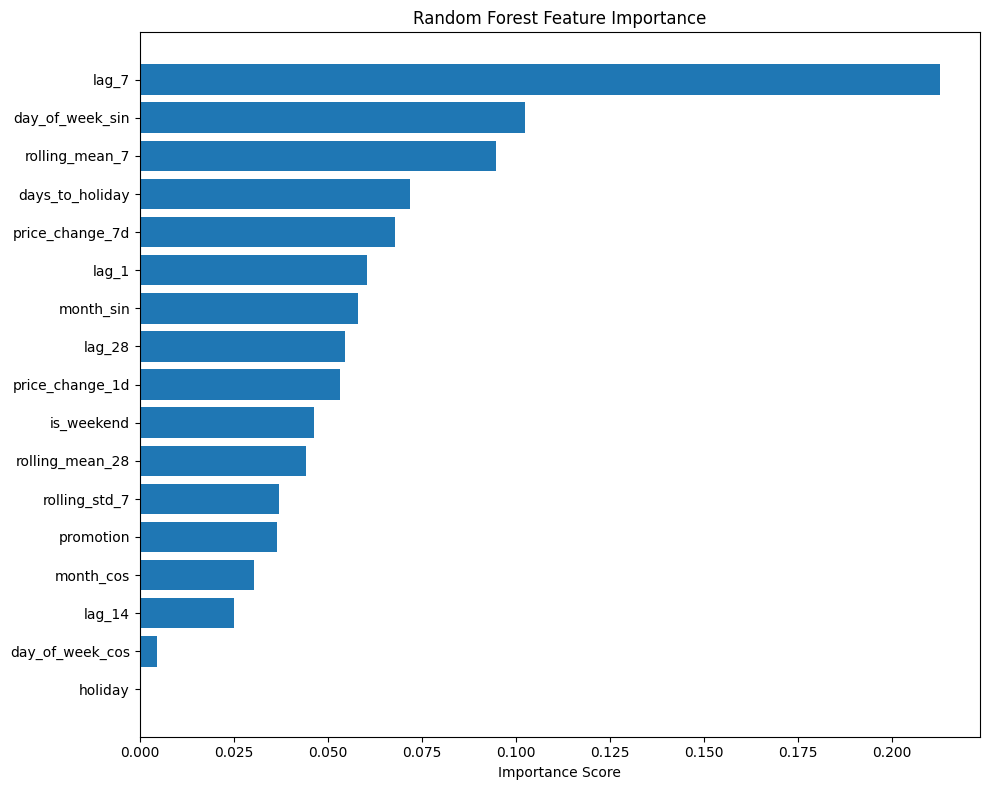

In [19]:
# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

## Visualizing ML vs Traditional Forecasts

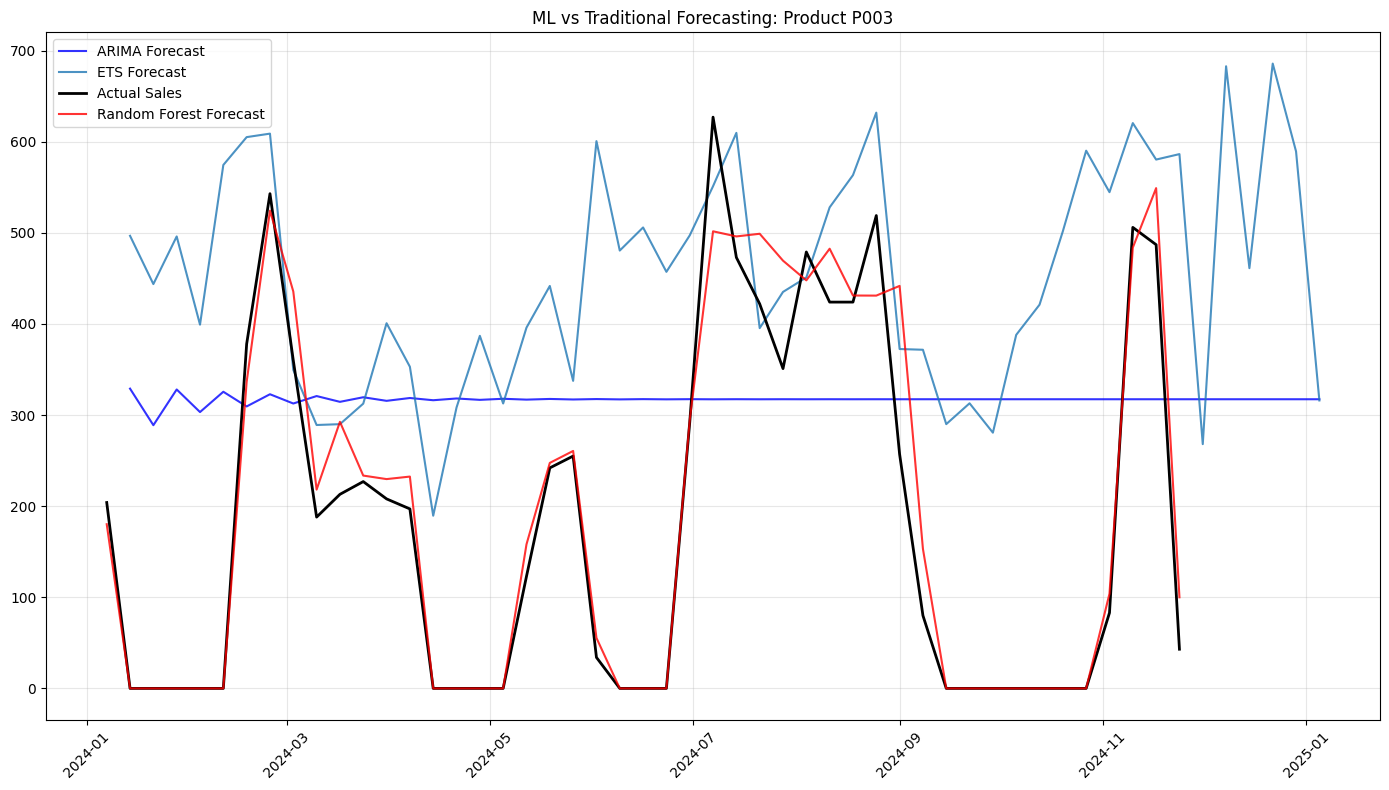

In [50]:
# Compare forecasts
plt.figure(figsize=(14, 8))

# Get the test period dates
test_dates = pd.Series(y_test.values, index=product_ml_clean[test_mask]['date'])
test_dates = test_dates.resample('W').sum()

test_rf_forecast = pd.Series(y_pred_rf, index=product_ml_clean[test_mask]['date'])
test_rf_forecast = test_rf_forecast.resample('W').sum()
# Arima serie test
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='blue', alpha=0.8)
# ETS forcast
plt.plot(test.index, ets_forecast, label='ETS Forecast', alpha=0.8)
#ML RF
plt.plot(test_dates.index, test_dates.values, label='Actual Sales', color='black', linewidth=2)
plt.plot(test_rf_forecast.index, test_rf_forecast.values, label='Random Forest Forecast', color='red', alpha=0.8)

plt.title('ML vs Traditional Forecasting: Product P003')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()